In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install tensorflow 2.15.0
# Note: tensorflow 2.17.0 is preinstalled in Google Colab
# however, there are compatibility issues between version 2.17.0 and the ART library
# therefore, this line will uninstall tensorflow 2.17.0 and wil install version 2.15.0
!pip install -q tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.71 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [3]:
# Install the ART library (provides adversarial attacks)
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.0 MB/s eta 0:00:00


In [4]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split

# This line is important, without it the attacks in the ART toolbox won't work
# when using the Keras ART classifier
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.15.0
Keras version:2.15.0


In [5]:
# Create a new directory for saving the dataset
os.makedirs('sample_data/oxford_flowers', exist_ok=True)

In [6]:
# Download the dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2025-01-27 04:15:04--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2025-01-27 04:15:04--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-01-27 04:15:05--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [7]:
# Uncompress the dataset
!tar -zxvf 102flowers.tgz -C 'sample_data/oxford_flowers' > /dev/null 2>&1

In [8]:
# Function to load the images
def load_images(directory):

    imgs_list = []

    # List with the names of the images
    imagesList = listdir(directory)
    # Make sure that the images are sorted in ascending order
    imagesList = natsort.natsorted(imagesList)

    # Read the images
    for i in range(len(imagesList)):
      tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
      # Resize all images to 128 x 128 pixels
      resized_img = cv2.resize(tmp_img, (128, 128))
      # Convert the images to numpy arrays
      img_arr = np.array(resized_img)
      imgs_list.append(img_arr/255.)

    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

# Use the above function to load the dataset
images = load_images('sample_data/oxford_flowers/jpg')

In [9]:
# Check the shape of the images
images.shape

(8189, 128, 128, 3)

In [10]:
# Download the file with the labels
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

URL transformed to HTTPS due to an HSTS policy
--2025-01-27 04:16:10--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2025-01-27 04:16:10--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2025-01-27 04:16:11 (161 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [12]:
import scipy.io

In [13]:
# Load the labels from the file
labels_data = scipy.io.loadmat('imagelabels.mat')
labels = np.squeeze(labels_data['labels'])-1

In [14]:
# Check the shape of the labels
labels.shape

(8189,)

In [15]:
# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.15, random_state=12)

In [16]:
# Display the shapes of train and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (6960, 128, 128, 3) - Labels train shape: (6960,)
Images test shape: (1229, 128, 128, 3) - Labels test shape: (1229,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.3670719956896727
Data type float64


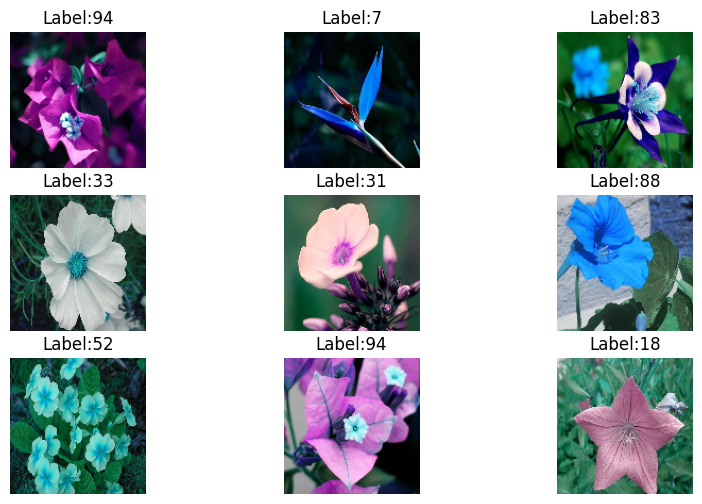

In [17]:
# Plot a few images and labels
plt.figure(figsize=(10, 6))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(train_labels[i[0]]))
    plt.axis('off')

In [18]:
# Asscociate the labels and names of flowers
flower_names = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

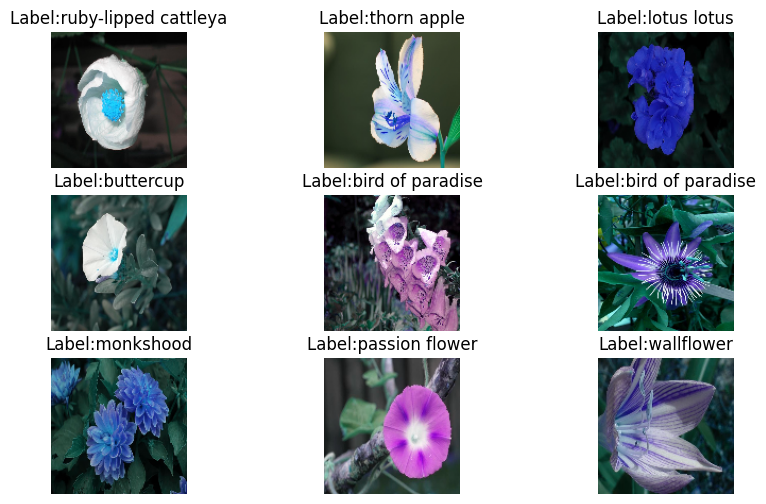

In [19]:
# Plot a few images and the flower names
plt.figure(figsize=(10, 6))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(flower_names[str(train_labels[n]+1)]))
    plt.axis('off')

In [22]:
NUM_CLASSES = 102

In [23]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import vgg16
from tensorflow.keras.utils import to_categorical

import datetime
now = datetime.datetime.now

In [30]:

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add fully-connected layers
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a softmax layer with 10 classes
predictions = Dense(102, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
# Compile the model
# Instead of using Adam directly, use the legacy version if needed.
from tensorflow.keras.optimizers.legacy import Adam
# OR
# from tensorflow.keras.optimizers import legacy
# model.compile(optimizer=legacy.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

# Create validation sets from the training data
# You can adjust the 'validation_split' value as needed
# Capture the start time for training
t = now()
history = model.fit(train_images, train_labels, epochs=100, batch_size=32,
                     validation_split=0.15, verbose=1, callbacks=callbacks)
print('Training time: %s' % (now() - t))


Train on 5916 samples, validate on 1044 samples
Epoch 1/100
5916/5916 [==============================] - 30s 5ms/sample - loss: 4.5423 - accuracy: 0.0363 - val_loss: 4.3897 - val_accuracy: 0.0441
Epoch 2/100
5916/5916 [==============================] - 28s 5ms/sample - loss: 4.1997 - accuracy: 0.0668 - val_loss: 3.8759 - val_accuracy: 0.0872
Epoch 3/100
5916/5916 [==============================] - 28s 5ms/sample - loss: 3.6743 - accuracy: 0.1215 - val_loss: 3.2284 - val_accuracy: 0.2117
Epoch 4/100
5916/5916 [==============================] - 29s 5ms/sample - loss: 3.0112 - accuracy: 0.2355 - val_loss: 2.5883 - val_accuracy: 0.3487
Epoch 5/100
5916/5916 [==============================] - 29s 5ms/sample - loss: 2.3269 - accuracy: 0.3857 - val_loss: 1.8686 - val_accuracy: 0.5144
Epoch 6/100
5916/5916 [==============================] - 28s 5ms/sample - loss: 1.7690 - accuracy: 0.5085 - val_loss: 1.5868 - val_accuracy: 0.5661
Epoch 7/100
5916/5916 [==============================] - 28s 5ms

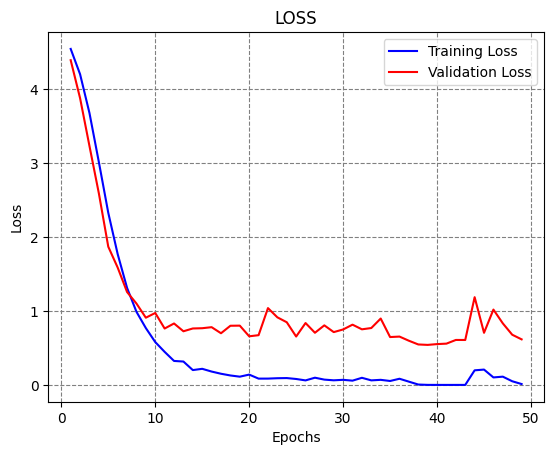

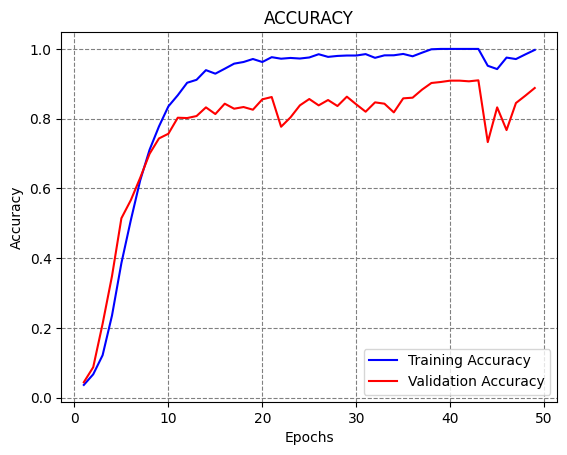

In [32]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [43]:
# Evaluate on train images
evals_train = model.evaluate(train_images, train_labels)
print("Classification Accuracy: ", evals_train[1])


Classification Accuracy:  0.98261493


In [33]:
# Evaluate on test images
evals_test = model.evaluate(test_images, test_labels)
print("Classification Accuracy: ", evals_test[1])


Classification Accuracy:  0.87306756


In [34]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

In [35]:

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [36]:
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [37]:
# Use the first 200 test images for creating adversarial samples
adv_imgs = test_images[0:200]
adv_labels = test_labels[0:200]

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy on adversarial test data: 87.00%
Average perturbation: 0.00


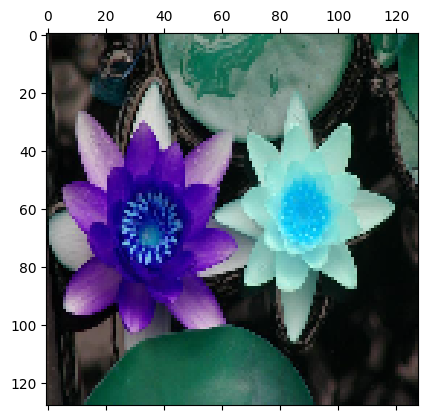

Accuracy on adversarial test data: 69.50%
Average perturbation: 0.00


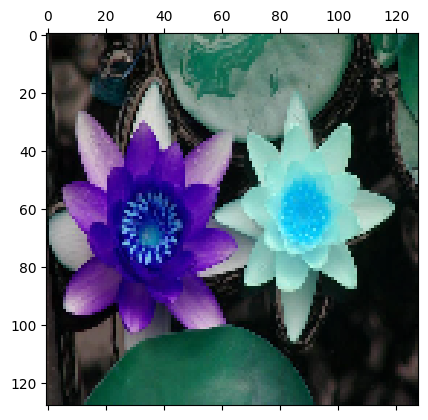

Accuracy on adversarial test data: 41.50%
Average perturbation: 0.01


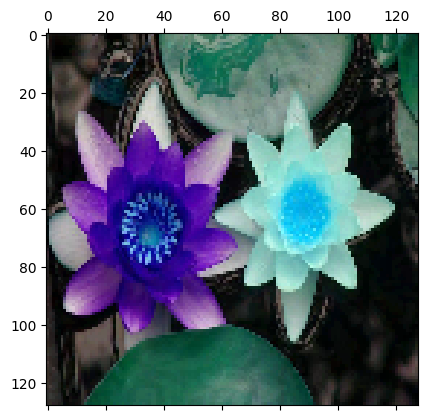

Accuracy on adversarial test data: 32.00%
Average perturbation: 0.02


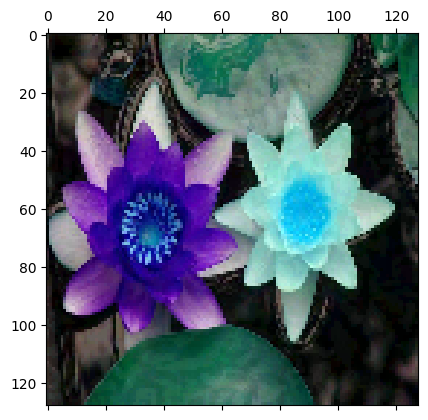

Accuracy on adversarial test data: 31.00%
Average perturbation: 0.03


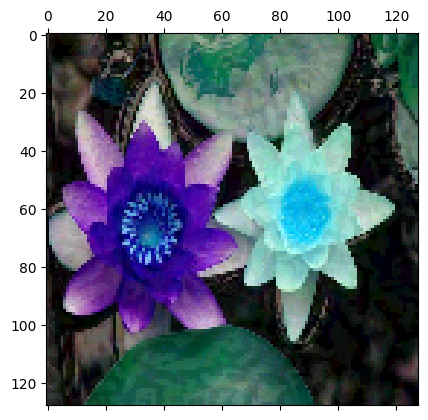

Accuracy on adversarial test data: 23.50%
Average perturbation: 0.07


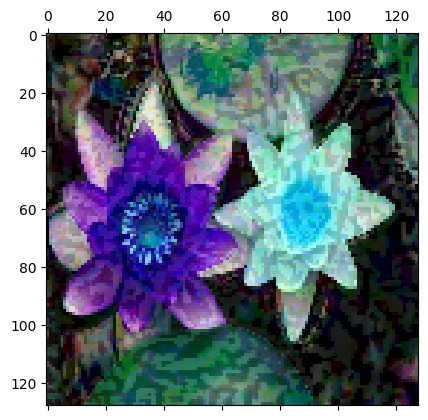

Accuracy on adversarial test data: 10.50%
Average perturbation: 0.17


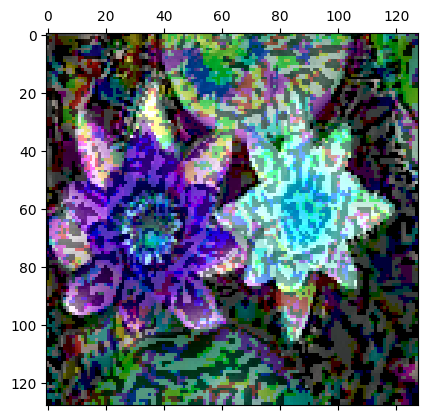

Accuracy on adversarial test data: 6.00%
Average perturbation: 0.25


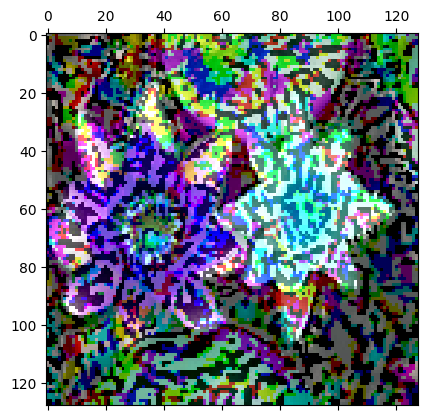

In [38]:
# FGSM attack
epsilon = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs, adv_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
    plt.show()

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 87.00%
Average perturbation: 0.00


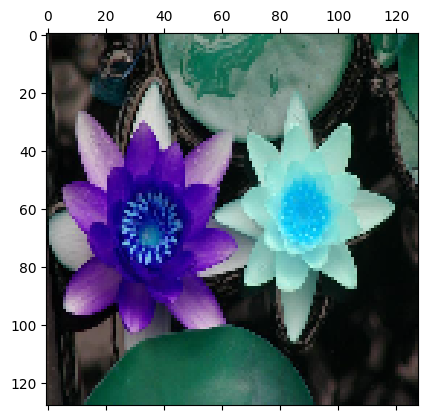

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 65.00%
Average perturbation: 0.00


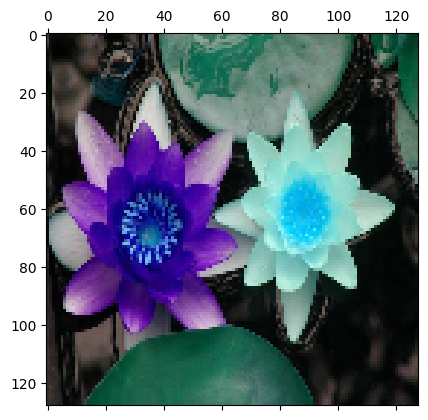

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 30.00%
Average perturbation: 0.01


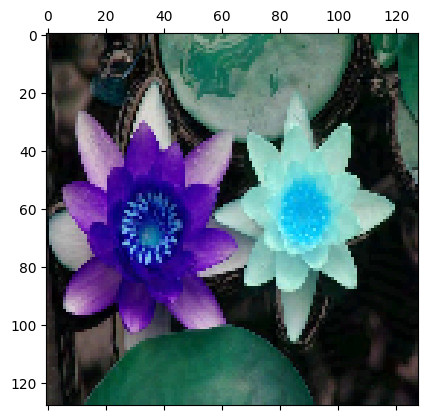

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 22.00%
Average perturbation: 0.02


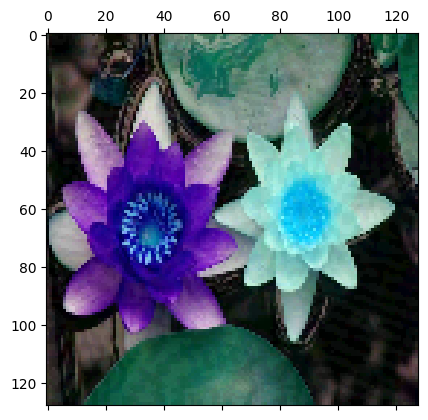

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 16.50%
Average perturbation: 0.03


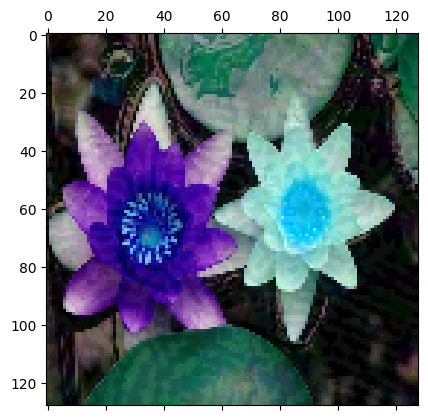

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 6.50%
Average perturbation: 0.06


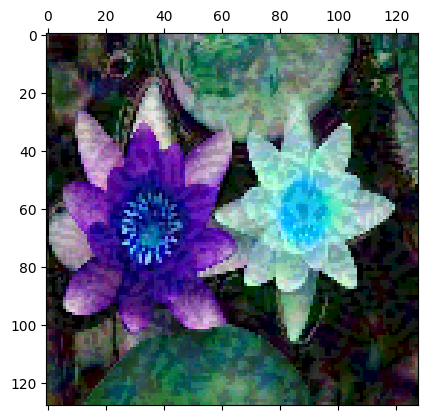

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 6.00%
Average perturbation: 0.13


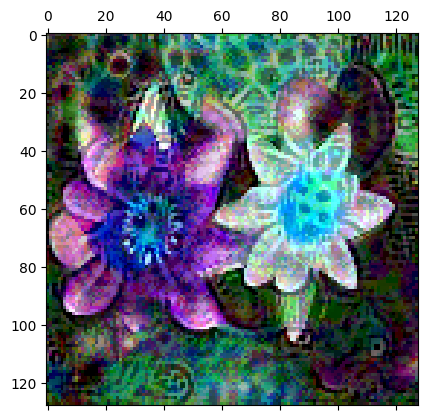

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 6.00%
Average perturbation: 0.19


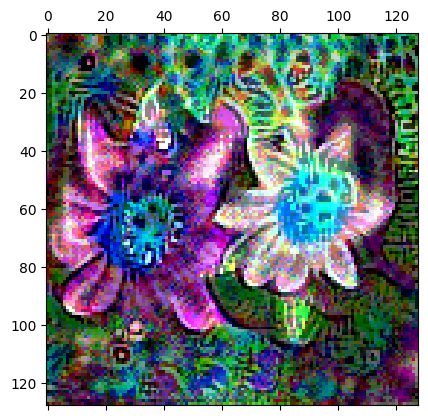

In [39]:
# PGD attack

pgd_attack_acc = []
for eps in epsilon:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps)
    pgd_attack_adv_imgs = attack_pgd.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs, adv_labels)
    pgd_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(pgd_attack_adv_imgs[0]))
    plt.show()

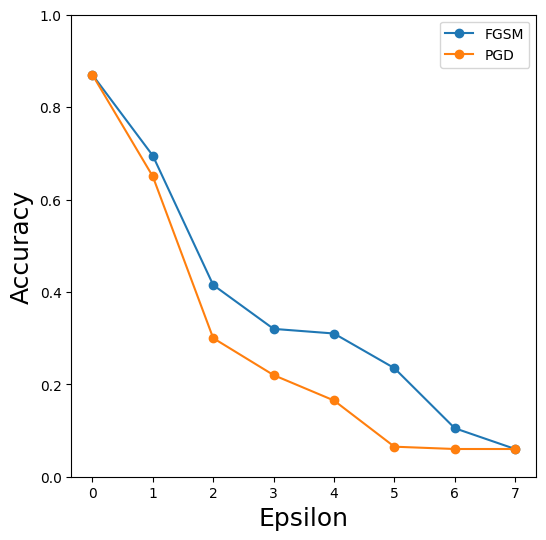

In [40]:
# Plot the success rate of FGSM and PGD attacks
attack_name = ['FGSM', 'PGD']
attack_acc = [fgsm_attack_acc, pgd_attack_acc]

plt.figure(figsize=(6,6))
plt.ylim(0, 1)
plt.xlabel('Epsilon', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
for i in range(len(attack_name)):
    plt.plot(attack_acc[i], marker='o', label=attack_name[i])
plt.legend(loc='upper right')
plt.show()


Perturbation maginutude: 0.0118
Predicted label: bishop of llandaff
Perturbation maginutude: 0.0314
Predicted label: bishop of llandaff
Perturbation maginutude: 0.0784
Predicted label: bishop of llandaff
Perturbation maginutude: 0.1961
Predicted label: wallflower
Perturbation maginutude: 0.3137
Predicted label: wallflower


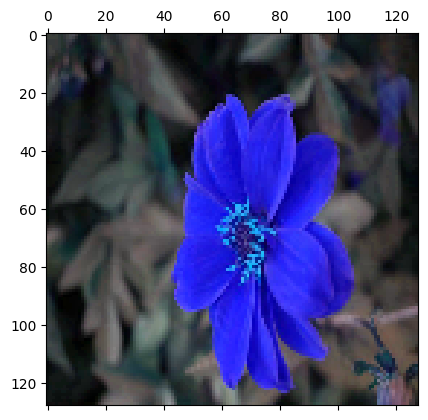

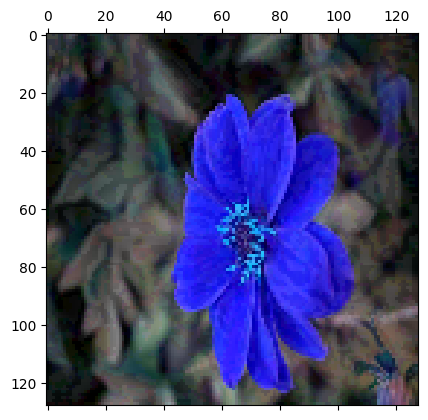

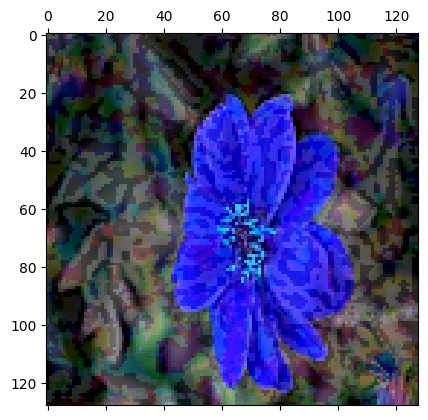

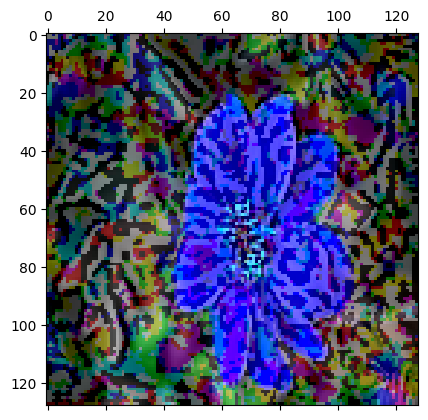

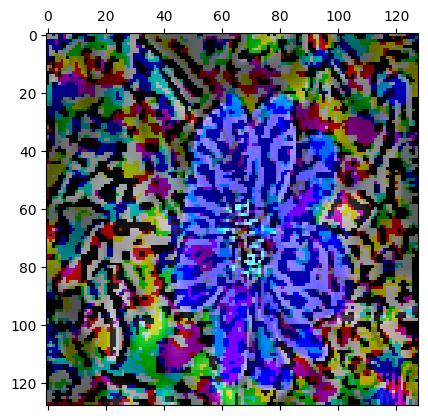

In [42]:
# Plot figures for the FGSM attack
epsilon1 = [3./255, 8./255, 20./255, 50./255, 80./255]

for eps in epsilon1:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs[3:4])
    print('Perturbation maginutude: {:5.4f}'.format(eps))
    preds = model.predict(fgsm_attack_adv_imgs)
    predicted_label = np.argmax(preds[0], axis=-1) + 1 # Add 1 because labels start from 0 but flower_names keys start from 1
    print('Predicted label:', str(flower_names[str(predicted_label)])) # Use flower_names instead of label_names and convert label to string
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))